# Forecasting Gross Broadway Sales using Facebook Prophet

Our goal in this notebook is to use Facebook Prophet to build a model that will predict the gross sales for a particular theater; in this case, Majestic Theatre. We will not perform any tuning of the model in this notebook; for this we refer to the notebook "Prophet_model_Majestic_theatre_holidays_and_cv.ipynb".

The notebook is organized into the following sections:

1. Setup, where we import packages and the raw data.

2. Creating a DataFrame to feed to Prophet, where we extract the data on weekly gross sales for the Majestic Theatre.

3. Building a model, where we fit a Prophet model to the DataFrame.

4. Diagnostics, where we evaluate the model using Mean Absolute Error, Root Mean Squared Error, and Mean Absolute Percentage Error.


## Setup

Let us first import the packages we need.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

sns.set_style("whitegrid")

Next, we read in the data file `grosses.csv`.

In [2]:
df_raw = pd.read_csv('../DATA-COLLECTION/grosses.csv')
df_raw.head()

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
0,1985-06-09,1,3915937.0,42nd Street,St. James Theatre,282368.0,NaN,30.42,NaN,9281,1655,0.7010,8,0
1,1985-06-09,1,3915937.0,A Chorus Line,Sam S. Shubert Theatre,222584.0,NaN,27.25,NaN,8167,1472,0.6935,8,0
2,1985-06-09,1,3915937.0,Aren't We All?,Brooks Atkinson Theatre,249272.0,NaN,33.75,NaN,7386,1088,0.8486,8,0
3,1985-06-09,1,3915937.0,Arms and the Man,Circle in the Square Theatre,95688.0,NaN,20.87,NaN,4586,682,0.8405,8,0
4,1985-06-09,1,3915937.0,As Is,Lyceum Theatre,61059.0,NaN,20.78,NaN,2938,684,0.5369,8,0


Next, we perform a bit of exploration to see if there's anything odd about the data.

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47524 entries, 0 to 47523
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   week_ending           47524 non-null  object 
 1   week_number           47524 non-null  int64  
 2   weekly_gross_overall  47524 non-null  float64
 3   show                  47524 non-null  object 
 4   theatre               47524 non-null  object 
 5   weekly_gross          47524 non-null  float64
 6   potential_gross       34911 non-null  float64
 7   avg_ticket_price      47524 non-null  float64
 8   top_ticket_price      36167 non-null  float64
 9   seats_sold            47524 non-null  int64  
 10  seats_in_theatre      47524 non-null  int64  
 11  pct_capacity          47524 non-null  float64
 12  performances          47524 non-null  int64  
 13  previews              47524 non-null  int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 5.1+ MB


The columns we're interested in are `week_ending`, `theatre`, and `weekly_gross`. Happily, none of these columns have null values.

Let's also get some simple stats to get an idea of the numbers we're working with.

In [4]:
df_raw.describe()

,week_number,weekly_gross_overall,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
count,47524.000000,4.752400e+04,4.752400e+04,3.491100e+04,47524.000000,36167.000000,47524.000000,47524.000000,47524.000000,47524.000000,47524.000000
mean,27.372170,1.669303e+07,5.744868e+05,9.395982e+05,67.914736,189.681892,7893.449668,1237.793536,0.802753,7.237754,0.583663
std,15.310139,9.520198e+06,4.433470e+05,4.193233e+05,38.589416,112.304515,3186.019908,358.357398,0.176418,2.229733,1.926202
min,1.000000,2.474396e+06,0.000000e+00,7.754000e+03,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,9.093031e+06,2.622292e+05,6.295230e+05,43.370000,85.000000,5442.000000,1021.000000,0.691400,8.000000,0.000000
50%,28.000000,1.506067e+07,4.700645e+05,9.031500e+05,60.235000,200.000000,7736.000000,1181.000000,0.833000,8.000000,0.000000
75%,41.000000,2.289759e+07,7.584381e+05,1.190502e+06,84.652500,250.000000,10187.000000,1509.000000,0.953800,8.000000,0.000000
max,53.000000,5.780727e+07,4.041493e+06,3.559306e+06,511.580000,998.000000,24305.000000,1969.000000,1.553600,17.000000,16.000000


## Creating a DataFrame to feed to Prophet

Prophet requires a two-column DataFrame to build a model; the first column must be in `datetime` format, and the second column must be numerical. We need to manipulate `df_raw` to get the weekly grosses of Majestic Theatre, indexed by the ending week.

First, let's extract all of the rows that have 'Majestic Theatre' in the `theatre` column.

In [5]:
df_raw['theatre'].unique()

array(['St. James Theatre', 'Sam S. Shubert Theatre',
       'Brooks Atkinson Theatre', 'Circle in the Square Theatre',
       'Lyceum Theatre', "Eugene O'Neill Theatre", 'Neil Simon Theatre',
       '46th Street Theatre', 'Winter Garden Theatre', 'Ritz Theatre',
       'Mark Hellinger Theatre', 'Palace Theatre', 'Ambassador Theatre',
       'Edison Theatre', 'Gershwin Theatre', 'Booth Theatre',
       'Broadway Theatre', 'Broadhurst Theatre', 'Minskoff Theatre',
       'Royale Theatre', 'Plymouth Theatre', 'Lunt-Fontanne Theatre',
       'Helen Hayes Theatre', 'Biltmore Theatre', 'Imperial Theatre',
       'John Golden Theatre', 'Music Box Theatre', 'Nederlander Theatre',
       'Ethel Barrymore Theatre', 'Longacre Theatre', 'Virginia Theatre',
       'Jack Lawrence Theatre', 'Vivian Beaumont Theater',
       'Marquis Theatre', 'Cort Theatre', 'Martin Beck Theatre',
       'Majestic Theatre', 'Criterion Center Stage Right',
       'Belasco Theatre', 'Richard Rodgers Theatre',
       '

In [6]:
df_majestic = df_raw[df_raw['theatre'] == 'Majestic Theatre']

Next, let's drop all columns except for `week_ending` and `weekly_gross`.

In [7]:
df_week_gross_series = df_majestic[['week_ending', 'weekly_gross']]

And convert the `week_ending` column from string to `datetime` format.

In [8]:
df_week_gross_series['week_ending'] = pd.to_datetime(df_week_gross_series['week_ending'])

<ipython-input-8-c999bfa3789d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_gross_series['week_ending'] = pd.to_datetime(df_week_gross_series['week_ending'])


Also, Prophet has the requirement that the two columns must be titled 'ds' and 'y', so let's rename them.

In [9]:
df_week_gross_series = df_week_gross_series.rename(columns={'week_ending': 'ds', 'weekly_gross': 'y'})

Next, we extract all rows between the dates 2013-06-02 and 2018-05-27, and preview the final DataFrame.

In [10]:
from datetime import datetime

train_start_date = datetime.strptime('2013-06-02', '%Y-%m-%d')
train_end_date = datetime.strptime('2018-05-27', '%Y-%m-%d')

test_start_date = datetime.strptime('2018-06-03', '%Y-%m-%d')
test_end_date = datetime.strptime('2019-05-26', '%Y-%m-%d')

df_full = df_week_gross_series.loc[(df_week_gross_series.ds >= train_start_date) & (df_week_gross_series.ds <= test_end_date)].reset_index(drop = True)
df_train = df_full.loc[df_full.ds <= train_end_date]
df_test = df_full.loc[df_full.ds >= test_start_date]

Let's plot the evolution of the training data and the test data over time, to see how it looks.

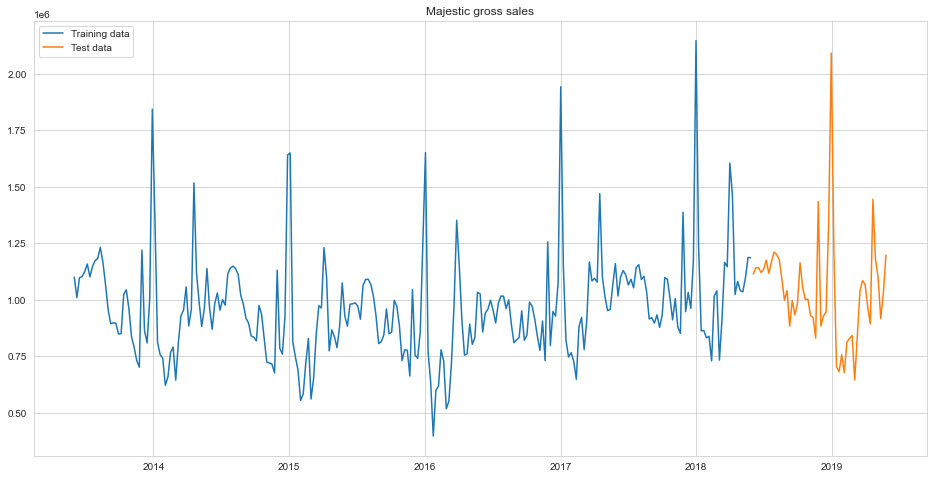

In [11]:
plt.figure(figsize=(16,8))
plt.plot(df_train['ds'], df_train['y'], label = 'Training data')
plt.plot(df_test['ds'], df_test['y'], label = 'Test data')
plt.title('Majestic gross sales')
plt.legend(loc = 'upper left')

## Building a model

We call Prophet and fit it to our DataFrame `df_train`.

In [12]:
m = Prophet()
m.fit(df_train)

13:55:13 - cmdstanpy - INFO - Chain [1] start processing
13:55:14 - cmdstanpy - INFO - Chain [1] done processing


Next, we fill out the date column with 52 weeks into the future.

In [13]:
future = m.make_future_dataframe(periods = 52, freq = 'W')
future.tail()

,ds
307,2019-04-28
308,2019-05-05
309,2019-05-12
310,2019-05-19
311,2019-05-26


Then we call the `predict` method on `future`, to get predictions $\hat y$.

In [14]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-06-02,1.078572e+06,909518.060715,1.241321e+06
1,2013-06-09,1.035982e+06,858694.219224,1.197995e+06
2,2013-06-16,1.021398e+06,870595.728681,1.191242e+06
3,2013-06-23,1.056216e+06,900344.215467,1.218336e+06
4,2013-06-30,1.093910e+06,929018.559123,1.261532e+06


## Diagnostics

Next, we want to evaluate how well the model did. We add the actual values $y_t$ and the errors $|y_t-\hat y_t|$ to the `forecast` Data Frame.

In [15]:
forecast['actuals'] = df_full['y']
forecast['error'] = np.abs(forecast['actuals'] - forecast['yhat'])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'actuals', 'error']].head(10)

,ds,yhat,yhat_lower,yhat_upper,actuals,error
0,2013-06-02,1.078572e+06,9.095181e+05,1.241321e+06,1100715.0,22143.436907
1,2013-06-09,1.035982e+06,8.586942e+05,1.197995e+06,1010069.0,25912.974334
2,2013-06-16,1.021398e+06,8.705957e+05,1.191242e+06,1097933.0,76534.720723
3,2013-06-23,1.056216e+06,9.003442e+05,1.218336e+06,1103158.0,46941.527051
4,2013-06-30,1.093910e+06,9.290186e+05,1.261532e+06,1124860.0,30949.941420
5,2013-07-07,1.087900e+06,9.193260e+05,1.247338e+06,1158635.0,70734.831061
6,2013-07-14,1.059921e+06,8.876334e+05,1.217344e+06,1101647.0,41726.124378
7,2013-07-21,1.072949e+06,9.055509e+05,1.233647e+06,1147544.0,74594.552017
8,2013-07-28,1.140211e+06,9.721346e+05,1.306697e+06,1173574.0,33362.577435
9,2013-08-04,1.192750e+06,1.033024e+06,1.360586e+06,1182528.0,10222.189867


Next we compute the errors on the test data to get an idea of how far off the predictions are.

In [16]:
n = df_test.index.values.astype(int)[0] #This is the index where the test data starts in df_full

test_errors = forecast['error'][n:]
rmse = np.sqrt(1/len(test_errors)*np.sum(test_errors**2))
mae = 1/len(test_errors)*np.sum(test_errors)
mape= 1/len(test_errors)*sum(test_errors/forecast['actuals'][n:])

print('The Root Mean Squared Error on the test data is $' + str(round(rmse, 2)) + '.')
print('The Mean Absolute Error on the test data is $' + str(round(mae, 2))+'.')
print('The Mean Absolute Percent Error on the test data is ' + str(round(mape*100, 2)) + '%.')

The Root Mean Squared Error on the test data is $206297.48.
The Mean Absolute Error on the test data is $165510.63.
The Mean Absolute Percent Error on the test data is 17.18%.


Below we plot the actual values against the predicted values, and plot the error below these two curves. The red dotted line indicates the separation between the train data and the test data (the model was trained only on the blue curve to the left of the red dotted line).

According to these diagnostics, the base Prophet model's predictions on the test data were significantly worse for the Majestic Theatre than the Gershwin Theatre. Because the absolute sales of the theaters were different, we cannot directly compare the RMSEs or MAEs. However, the MAPE of the base model's predictions for the Gershwin was 8.12% while that for the Majestic predictions was 17.18% Because neither of these models are identically specified according to the default settings in the `prophet` package, this difference could be due to differences in the data between the theaters.

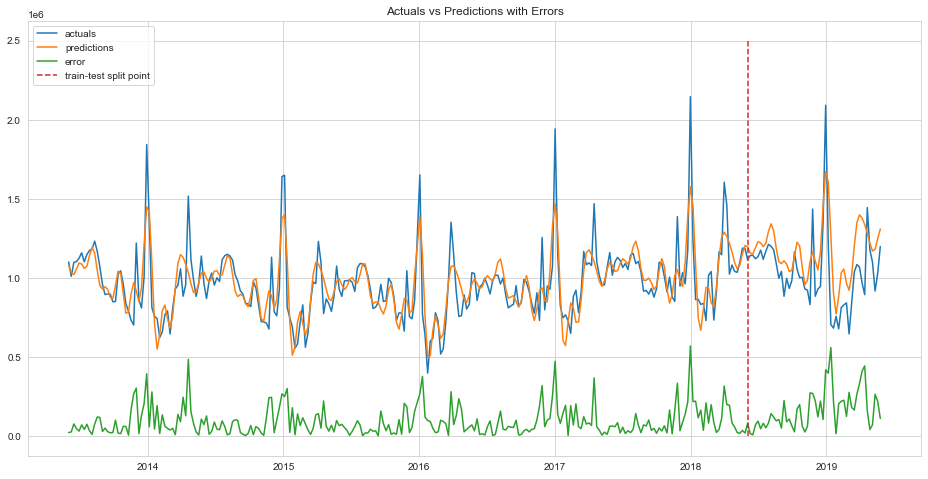

In [18]:
plt.figure(figsize=(16,8))
plt.plot(forecast['ds'], forecast['actuals'], label = 'actuals')
plt.plot(forecast['ds'], forecast['yhat'], label = 'predictions')
plt.plot(forecast['ds'], forecast['error'], label = 'error')
plt.plot([test_start_date, test_start_date], [0, 2500000], linestyle = '--', label = 'train-test split point')
plt.title('Actuals vs Predictions with Errors')
plt.legend(loc = 'upper left')

Though it appears that the model did an okay job of capturing yearly seasonality, we can see that the errors tend to peak when the actual values peak. This is likely because Prophet assumes that such large values are outliers, but on closer inspection, these peaks occur shortly after holidays (Christmas, Thanksgiving, and Easter). Examining the plots for the base models in this notebook and `Prophet_model_Gershwin_theatre_base_model`, we can see that base model's prediction curve for the Majestic changes significantly at the train-test split point. The reason for this is not immediately clear without a more in-depth understanding of the model's automatic fitting features, although our guess is that the model erroneously detected a changepoint in the trend of the data where none existed.

In the next notebook, we account for these points, and also perform cross-validation to see if we can lower the errors.